# Get Population Data from Google Earth Engine using GEEMap

In [4]:
import ee
import geemap

## Authenticate & Initialize GEE

Requires a [Google Cloud Project](https://console.cloud.google.com/projectcreate) and to enable the [Earth Engine API](https://console.cloud.google.com/apis/api/earthengine.googleapis.com) for the project. Find detailed instructions [here](https://book.geemap.org/chapters/01_introduction.html#earth-engine-authentication).

In [2]:
ee.Initialize()

## Create a GEEMap Object

In [3]:
# center over Africa
m = geemap.Map(
    center=[0, 10], 
    zoom=4, 
    basemap = 'Esri.WorldImagery',
    height = 800
)
m

Map(center=[0, 10], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [8]:
# get the current zoom and center of map
print(m.center, m.zoom)

[0, 10.019531250000002] 4.0


## Import Sites

In [5]:
import pandas as pd
import geopandas as gpd

## Clean Up GeoDataFrames

In [6]:
# read in geojson
gdf = gpd.read_file('data/cbil/cbil_sites.geojson')


# export into pop_cbilfolder
gdf.to_file('data/pop_cbil/sites.geojson', driver='GeoJSON')

## Get Countries in CLUB-ER Dataset

In [13]:
# remove any sites with null country
gdf = gdf[gdf['country'].notnull()]

# get countries of CLUB-ER Sites
mg_countries = gdf['country'].unique()

# rename DR Congo to Democratic Republic of the Congo
mg_countries = [x if x != 'DR Congo' else 'Democratic Republic of the Congo' for x in mg_countries]
# rename Tanzania to United Republic of Tanzania
mg_countries = [x if x != 'Tanzania' else 'United Republic of Tanzania' for x in mg_countries]
# remove haiti
mg_countries = [x for x in mg_countries if x != 'Haiti']

print('Mini-Grid Countries: ', mg_countries)
# print length of mg countries
print('Number of Mini-Grid Countries: ', len(mg_countries))

# overlay country boundaries with white borders
countries = ee.FeatureCollection('FAO/GAUL/2015/level0')
# create a fc of just the countries in all_minigrid_countries
mg_countries_fc = countries.filter(ee.Filter.inList('ADM0_NAME', mg_countries))

# add mg countries to map
m.addLayer(mg_countries_fc, {'color': 'white'}, 'Mini-Grid Countries')

Mini-Grid Countries:  ['Kenya', 'Sierra Leone', 'Democratic Republic of the Congo', 'Nigeria', 'United Republic of Tanzania', 'Zambia', 'Ghana', 'Mozambique', 'Benin']
Number of Mini-Grid Countries:  9


In [14]:
# read in lookup table for country codes
# country_codes = pd.read_csv('data/pop_cbil/country_codes.csv')

# pull in countries from restcountries.com
import requests
import json
url = 'https://restcountries.com/v3.1/all'
response = requests.get(url)
countries_json = json.loads(response.text)

# convert json to pandas dataframe
country_df = pd.json_normalize(countries_json)

# keep just the columns we need
country_df = country_df[['name.common','name.official','cca3', 'cca2', 'ccn3', 'region', 'subregion', 'latlng']]

# export to csv
country_df.to_csv('data/pop_cbil/country_codes.csv', index=False)

In [16]:
# read in country_codes.csv
country_df = pd.read_csv('data/pop_cbil/country_codes.csv')

# change the official names back to common names in mg_countries
mg_countries = ['DR Congo' if x == 'Democratic Republic of the Congo' else x for x in mg_countries]
mg_countries = ['Tanzania' if x == 'United Republic of Tanzania' else x for x in mg_countries]

# filter down to countries in mg_countries by name.official
mg_country_codes = country_df[country_df['name.common'].isin(mg_countries)]
mg_country_codes_list = mg_country_codes['cca3'].tolist()
mg_country_codes


,name.common,name.official,cca3,cca2,ccn3,region,subregion,latlng
7,Zambia,Republic of Zambia,ZMB,ZM,894.0,Africa,Eastern Africa,"[-15.0, 30.0]"
17,Kenya,Republic of Kenya,KEN,KE,404.0,Africa,Eastern Africa,"[1.0, 38.0]"
32,Ghana,Republic of Ghana,GHA,GH,288.0,Africa,Western Africa,"[8.0, -2.0]"
104,Benin,Republic of Benin,BEN,BJ,204.0,Africa,Western Africa,"[9.5, 2.25]"
150,Tanzania,United Republic of Tanzania,TZA,TZ,834.0,Africa,Eastern Africa,"[-6.0, 35.0]"
178,Mozambique,Republic of Mozambique,MOZ,MZ,508.0,Africa,Eastern Africa,"[-18.25, 35.0]"
187,Sierra Leone,Republic of Sierra Leone,SLE,SL,694.0,Africa,Western Africa,"[8.5, -11.5]"
212,Nigeria,Federal Republic of Nigeria,NGA,NG,566.0,Africa,Western Africa,"[10.0, 8.0]"
236,DR Congo,Democratic Republic of the Congo,COD,CD,180.0,Africa,Middle Africa,"[0.0, 25.0]"


## Create Composite Image with Population in Relevant Countries with Bands as Years

In [20]:
# fetch entire worldpop image collection on the ee server
worldpop = ee.ImageCollection("WorldPop/GP/100m/pop").select('population')

# filter to countries in mg_country_codes in the column cca3
mg_countries_codes = mg_country_codes['cca3'].tolist()
worldpop_mg = worldpop.filter(ee.Filter.inList('country', mg_countries_codes))

# get the list of countries still in the collection
worldpop_mg_countries = worldpop_mg.aggregate_array('country').getInfo()
# show just the unique values
worldpop_mg_countries = list(set(worldpop_mg_countries))
print('WorldPop Countries: ', worldpop_mg_countries)

worldpop_mg

WorldPop Countries:  ['TZA', 'SLE', 'COD', 'KEN', 'ZMB', 'BEN', 'NGA', 'MOZ', 'GHA']


In [21]:
# for each year 2000 to 2020, mosaic the images in the collection of the same year into a single image

# create a list to hold the images
worldpop_by_year_list = []

# loop through each year
for year in range(2000, 2021):
    # filter the collection to the year
    year_collection = worldpop_mg.filter(ee.Filter.eq('year', year))
    # mosaic the images in the collection
    year_image = year_collection.mosaic()
    # add the image to the list
    worldpop_by_year_list.append(year_image)

# create an image collection from the list of images
worldpop_by_year_ic = ee.ImageCollection(worldpop_by_year_list)

popVis = {
    'min': 0.0,
    'max': 200.0,
    'palette': ['24126c', '1fff4f', 'd4ff50']
}

# add the first image in the collection to the map
m.addLayer(worldpop_by_year_ic.first(), popVis, 'WorldPop 2000')

worldpop_by_year_ic

In [22]:
# convert the worldpop_mg image collection into a single image with one band for each year
worldpop_mg_stack = worldpop_by_year_ic.toBands()

# rename bands
band_names = ['{}_population'.format(year) for year in range(2000, 2021)]

# Set the band names of the stacked image
worldpop_mg_stack = worldpop_mg_stack.rename(band_names)

# print the worldpop_mg_stack image
worldpop_mg_stack

## Import Sites as Feature Collection and Sample Population Images

In [24]:
# recreate feature collection from geojson file
sites_fc = geemap.geojson_to_ee('data/pop_cbil/sites.geojson')

# add to map
m.addLayer(sites_fc, {}, 'Mini-Grid Sites')

# create 1km buffer around each site
# todo consider a 2km buffer
sites_fc_buffer = sites_fc.map(lambda f: f.buffer(1000))



In [25]:
# we can use the reduceRegions function to calculate the sum of the population within each buffer
# calculate the sum of the population within each buffer for every image "band"
pop_fc = worldpop_mg_stack.reduceRegions(
    collection=sites_fc_buffer,
    reducer=ee.Reducer.sum(),
    scale=100
)

# convert the cicular buffers back to points
pop_fc = pop_fc.map(lambda feature: feature.centroid())

In [26]:
# export the feature collection to a geopandas dataframe
pop_gdf = geemap.ee_to_geopandas(pop_fc)

# replace all column names containing 'SLE_' with ''
pop_gdf.columns = pop_gdf.columns.str.replace('_population', '')

# export the geopandas dataframe to a geojson file
pop_gdf.to_file('data/pop_cbil/pop.geojson', driver='GeoJSON')

### Clean Up the DataFrame

In [27]:
# read in the geojson as gdf
pop_gdf = gpd.read_file('data/pop_cbil/pop.geojson')
gdf = pop_gdf

# check for duplicate geometries
duplicates = gdf[gdf.duplicated(subset='geometry', keep=False)]
duplicates

# keep just the first instance of each duplicate geometry
gdf = gdf.drop_duplicates(subset='geometry', keep='first')

# drop any sites commissioned in 2000
gdf = gdf[gdf['date_commissioned'] != '2000-01-01']

# rexport to geojson
gdf.to_file('data/pop_cbil/pop_clean.geojson', driver='GeoJSON')


KeyError: 'date_commissioned'

## Melt the DataFrame

In [10]:
# read in the geojson as gdf
gdf = gpd.read_file('data/pop_cbil/pop_clean.geojson')

# keep just the columns we need
gdf = gdf[['site_name', 'date_commissioned', 'country', 'geometry'] + [str(year) for year in range(2000, 2021)]]

# melt the dataframe
gdf = gdf.melt(id_vars=['site_name', 'date_commissioned', 'country', 'geometry'], var_name='year', value_name='population')

# convert date_commissioned from string '2020-01-01' to a integer year 2020
gdf['date_commissioned'] = pd.to_datetime(gdf['date_commissioned']).dt.year
# convert year to an integer
gdf['year'] = gdf['year'].astype(int)

# export the dataframe to a csv
gdf.to_file('data/pop_cbil/pop_melt.geojson', driver='GeoJSON')

## Visualize the Results

/Users/ilyonsg/miniconda3/envs/gee/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ilyonsg/miniconda3/envs/gee/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ilyonsg/miniconda3/envs/gee/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ilyonsg/miniconda3/envs/gee/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

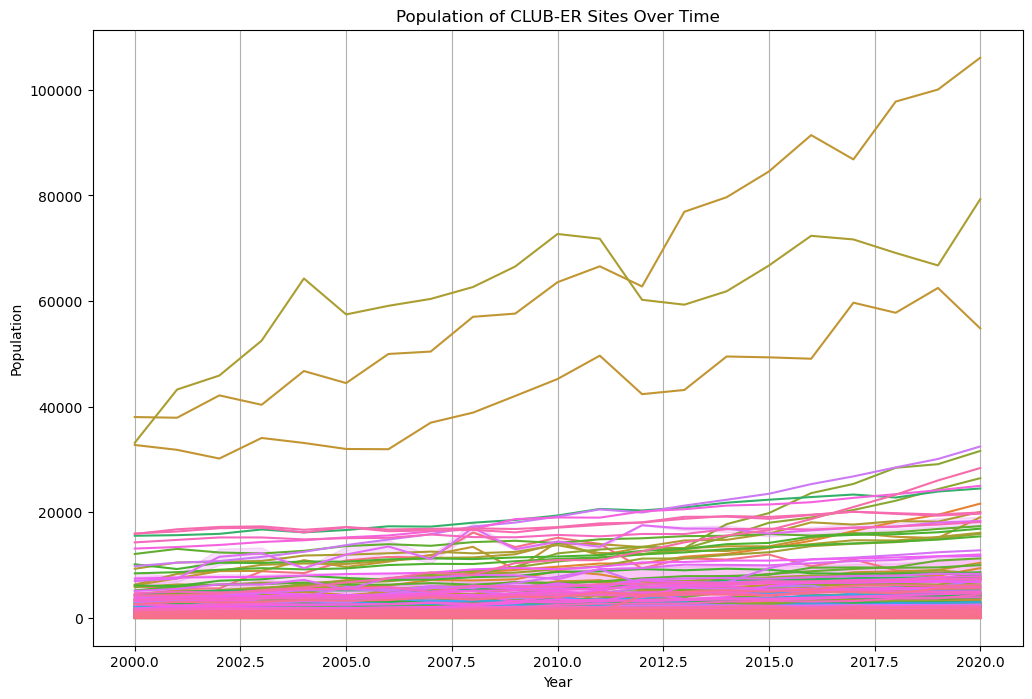

In [11]:
# plot the population of each site over time
import matplotlib.pyplot as plt
import seaborn as sns

# read in the geojson as gdf
gdf = gpd.read_file('data/pop_cbil/pop_melt.geojson')

# plot each of the population points by year with major gridlines at each year
plt.figure(figsize=(12, 8))
sns.lineplot(data=gdf, x='year', y='population', hue='site_name')
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Population of CLUB-ER Sites Over Time')
# hide legend
plt.legend().remove()
plt.grid(which='major', axis='x')
plt.show()
